##### Copyright 2018 The TensorFlow Authors.

Licensed under the Apache License, Version 2.0 (the "License").

# Neural Machine Translation with Attention

<table class="tfo-notebook-buttons" align="left"><td>
<a target="_blank"  href="https://colab.research.google.com/github/tensorflow/tensorflow/blob/master/tensorflow/contrib/eager/python/examples/nmt_with_attention/nmt_with_attention.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>  
</td><td>
<a target="_blank"  href="https://github.com/tensorflow/tensorflow/tree/master/tensorflow/contrib/eager/python/examples/nmt_with_attention/nmt_with_attention.ipynb"><img width=32px src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a></td></table>

This notebook trains a sequence to sequence (seq2seq) model for Spanish to English translation using [tf.keras](https://www.tensorflow.org/programmers_guide/keras) and [eager execution](https://www.tensorflow.org/programmers_guide/eager). This is an advanced example that assumes some knowledge of sequence to sequence models.

After training the model in this notebook, you will be able to input a Spanish sentence, such as *"¿todavia estan en casa?"*, and return the English translation: *"are you still at home?"*

The translation quality is reasonable for a toy example, but the generated attention plot is perhaps more interesting. This shows which parts of the input sentence has the model's attention while translating:

<img src="https://tensorflow.org/images/spanish-english.png" alt="spanish-english attention plot">

Note: This example takes approximately 10 mintues to run on a single P100 GPU.

In [1]:
from __future__ import absolute_import, division, print_function

# Import TensorFlow >= 1.10 and enable eager execution
import tensorflow as tf

tf.enable_eager_execution()

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import unicodedata
import re
import numpy as np
import os
import time

print(tf.__version__)

C:\ProgramData\Anaconda3\envs\py35\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


1.10.0


## Download and prepare the dataset

We'll use a language dataset provided by http://www.manythings.org/anki/. This dataset contains language translation pairs in the format:

```
May I borrow this book?	¿Puedo tomar prestado este libro?
```

There are a variety of languages available, but we'll use the English-Spanish dataset. For convenience, we've hosted a copy of this dataset on Google Cloud, but you can also download your own copy. After downloading the dataset, here are the steps we'll take to prepare the data:

1. Add a *start* and *end* token to each sentence.
2. Clean the sentences by removing special characters.
3. Create a word index and reverse word index (dictionaries mapping from word → id and id → word).
4. Pad each sentence to a maximum length.

In [2]:
# Download the file
path_to_zip = tf.keras.utils.get_file(
    'hin-eng.zip', origin='http://www.manythings.org/anki/hin-eng.zip', 
    extract=True)

path_to_file = os.path.dirname(path_to_zip)+"/hin.txt"

In [3]:
# Converts the unicode file to ascii
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')


def preprocess_sentence(w):
    w = unicode_to_ascii(w.lower().strip())
    
    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ." 
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)
    
    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)
    
    w = w.rstrip().strip()
    
    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    w = '<start> ' + w + ' <end>'
    return w

In [4]:
# 1. Remove the accents
# 2. Clean the sentences
# 3. Return word pairs in the format: [ENGLISH, SPANISH]
def create_dataset(path, num_examples):
    lines = open(path, encoding='UTF-8').read().strip().split('\n')
    
    word_pairs = [[preprocess_sentence(w) for w in l.split('\t')]  for l in lines[:num_examples]]
    
    return word_pairs

In [5]:
# This class creates a word -> index mapping (e.g,. "dad" -> 5) and vice-versa 
# (e.g., 5 -> "dad") for each language,
class LanguageIndex():
    def __init__(self, lang):
        self.lang = lang
        self.word2idx = {}
        self.idx2word = {}
        self.vocab = set()

        self.create_index()
    
    def create_index(self):
        for phrase in self.lang:
            self.vocab.update(phrase.split(' '))

        self.vocab = sorted(self.vocab)

        self.word2idx['<pad>'] = 0
        for index, word in enumerate(self.vocab):
             self.word2idx[word] = index + 1
  
        for word, index in self.word2idx.items():
             self.idx2word[index] = word

In [6]:
def max_length(tensor):
    return max(len(t) for t in tensor)


def load_dataset(path, num_examples):
    # creating cleaned input, output pairs
    pairs = create_dataset(path, num_examples)

    # index language using the class defined above    
    inp_lang = LanguageIndex(sp for en, sp in pairs)
    targ_lang = LanguageIndex(en for en, sp in pairs)
    
    # Vectorize the input and target languages
    
    # Spanish sentences
    input_tensor = [[inp_lang.word2idx[s] for s in sp.split(' ')] for en, sp in pairs]
    
    # English sentences
    target_tensor = [[targ_lang.word2idx[s] for s in en.split(' ')] for en, sp in pairs]
    
    # Calculate max_length of input and output tensor
    # Here, we'll set those to the longest sentence in the dataset
    max_length_inp, max_length_tar = max_length(input_tensor), max_length(target_tensor)
    
    # Padding the input and output tensor to the maximum length
    input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, 
                                                                 maxlen=max_length_inp,
                                                                 padding='post')
    
    target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_tensor, 
                                                                  maxlen=max_length_tar, 
                                                                  padding='post')
    
    return input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_tar

### Limit the size of the dataset to experiment faster (optional)

Training on the complete dataset of >100,000 sentences will take a long time. To train faster, we can limit the size of the dataset to 30,000 sentences (of course, translation quality degrades with less data):

In [7]:
# Try experimenting with the size of that dataset
num_examples = 30000
input_tensor, target_tensor, inp_lang, targ_lang, max_length_inp, max_length_targ = load_dataset(path_to_file, num_examples)

In [8]:
# Creating training and validation sets using an 80-20 split
input_tensor_train, input_tensor_val, target_tensor_train, target_tensor_val = train_test_split(input_tensor, target_tensor, test_size=0.2)

# Show length
len(input_tensor_train), len(target_tensor_train), len(input_tensor_val), len(target_tensor_val)

(2264, 2264, 567, 567)

### Create a tf.data dataset

In [9]:
BUFFER_SIZE = len(input_tensor_train)
BATCH_SIZE = 64
N_BATCH = BUFFER_SIZE//BATCH_SIZE
embedding_dim = 256
units = 1024
vocab_inp_size = len(inp_lang.word2idx)
vocab_tar_size = len(targ_lang.word2idx)

dataset = tf.data.Dataset.from_tensor_slices((input_tensor_train, target_tensor_train)).shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)

## Write the encoder and decoder model

Here, we'll implement an encoder-decoder model with attention which you can read about in the TensorFlow [Neural Machine Translation (seq2seq) tutorial](https://github.com/tensorflow/nmt). This example uses a more recent set of APIs. This notebook implements the [attention equations](https://github.com/tensorflow/nmt#background-on-the-attention-mechanism) from the seq2seq tutorial. The following diagram shows that each input word is assigned a weight by the attention mechanism which is then used by the decoder to predict the next word in the sentence.

<img src="https://www.tensorflow.org/images/seq2seq/attention_mechanism.jpg" width="500" alt="attention mechanism">

The input is put through an encoder model which gives us the encoder output of shape *(batch_size, max_length, hidden_size)* and the encoder hidden state of shape *(batch_size, hidden_size)*. 

Here are the equations that are implemented:

<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_0.jpg" alt="attention equation 0" width="800">
<img src="https://www.tensorflow.org/images/seq2seq/attention_equation_1.jpg" alt="attention equation 1" width="800">

We're using *Bahdanau attention*. Lets decide on notation before writing the simplified form:

* FC = Fully connected (dense) layer
* EO = Encoder output
* H = hidden state
* X = input to the decoder

And the pseudo-code:

* `score = FC(tanh(FC(EO) + FC(H)))`
* `attention weights = softmax(score, axis = 1)`. Softmax by default is applied on the last axis but here we want to apply it on the *1st axis*, since the shape of score is *(batch_size, max_length, 1)*. `Max_length` is the length of our input. Since we are trying to assign a weight to each input, softmax should be applied on that axis.
* `context vector = sum(attention weights * EO, axis = 1)`. Same reason as above for choosing axis as 1.
* `embedding output` = The input to the decoder X is passed through an embedding layer.
* `merged vector = concat(embedding output, context vector)`
* This merged vector is then given to the GRU
  
The shapes of all the vectors at each step have been specified in the comments in the code:

In [10]:
def gru(units):
  # If you have a GPU, we recommend using CuDNNGRU(provides a 3x speedup than GRU)
  # the code automatically does that.
    if tf.test.is_gpu_available():
        return tf.keras.layers.CuDNNGRU(units, 
                                    return_sequences=True, 
                                    return_state=True, 
                                    recurrent_initializer='glorot_uniform')
    else:
        return tf.keras.layers.GRU(units, 
                               return_sequences=True, 
                               return_state=True, 
                               recurrent_activation='sigmoid', 
                               recurrent_initializer='glorot_uniform')

In [11]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, enc_units, batch_sz):
        super(Encoder, self).__init__()
        self.batch_sz = batch_sz
        self.enc_units = enc_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.enc_units)
        
    def call(self, x, hidden):
        x = self.embedding(x)
        output, state = self.gru(x, initial_state = hidden)        
        return output, state
    
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.enc_units))

In [12]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, dec_units, batch_sz):
        super(Decoder, self).__init__()
        self.batch_sz = batch_sz
        self.dec_units = dec_units
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        self.gru = gru(self.dec_units)
        self.fc = tf.keras.layers.Dense(vocab_size)
        
        # used for attention
        self.W1 = tf.keras.layers.Dense(self.dec_units)
        self.W2 = tf.keras.layers.Dense(self.dec_units)
        self.V = tf.keras.layers.Dense(1)
        
    def call(self, x, hidden, enc_output):
        # enc_output shape == (batch_size, max_length, hidden_size)
        
        # hidden shape == (batch_size, hidden size)
        # hidden_with_time_axis shape == (batch_size, 1, hidden size)
        # we are doing this to perform addition to calculate the score
        hidden_with_time_axis = tf.expand_dims(hidden, 1)
        
        # score shape == (batch_size, max_length, 1)
        # we get 1 at the last axis because we are applying tanh(FC(EO) + FC(H)) to self.V
        score = self.V(tf.nn.tanh(self.W1(enc_output) + self.W2(hidden_with_time_axis)))
        
        # attention_weights shape == (batch_size, max_length, 1)
        attention_weights = tf.nn.softmax(score, axis=1)
        
        # context_vector shape after sum == (batch_size, hidden_size)
        context_vector = attention_weights * enc_output
        context_vector = tf.reduce_sum(context_vector, axis=1)
        
        # x shape after passing through embedding == (batch_size, 1, embedding_dim)
        x = self.embedding(x)
        
        # x shape after concatenation == (batch_size, 1, embedding_dim + hidden_size)
        x = tf.concat([tf.expand_dims(context_vector, 1), x], axis=-1)
        
        # passing the concatenated vector to the GRU
        output, state = self.gru(x)
        
        # output shape == (batch_size * 1, hidden_size)
        output = tf.reshape(output, (-1, output.shape[2]))
        
        # output shape == (batch_size * 1, vocab)
        x = self.fc(output)
        
        return x, state, attention_weights
        
    def initialize_hidden_state(self):
        return tf.zeros((self.batch_sz, self.dec_units))

In [13]:
encoder = Encoder(vocab_inp_size, embedding_dim, units, BATCH_SIZE)
decoder = Decoder(vocab_tar_size, embedding_dim, units, BATCH_SIZE)

## Define the optimizer and the loss function

In [14]:
optimizer = tf.train.AdamOptimizer()


def loss_function(real, pred):
    mask = 1 - np.equal(real, 0)
    loss_ = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=real, logits=pred) * mask
    return tf.reduce_mean(loss_)

## Checkpoints (Object-based saving)

In [15]:
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

## Training

1. Pass the *input* through the *encoder* which return *encoder output* and the *encoder hidden state*.
2. The encoder output, encoder hidden state and the decoder input (which is the *start token*) is passed to the decoder.
3. The decoder returns the *predictions* and the *decoder hidden state*.
4. The decoder hidden state is then passed back into the model and the predictions are used to calculate the loss.
5. Use *teacher forcing* to decide the next input to the decoder.
6. *Teacher forcing* is the technique where the *target word* is passed as the *next input* to the decoder.
7. The final step is to calculate the gradients and apply it to the optimizer and backpropagate.

In [70]:
EPOCHS = 50

for epoch in range(EPOCHS):
    start = time.time()
    
    hidden = encoder.initialize_hidden_state()
    total_loss = 0
    
    for (batch, (inp, targ)) in enumerate(dataset):
        loss = 0
        
        with tf.GradientTape() as tape:
            enc_output, enc_hidden = encoder(inp, hidden)
            
            dec_hidden = enc_hidden
            
            dec_input = tf.expand_dims([targ_lang.word2idx['<start>']] * BATCH_SIZE, 1)       
            
            # Teacher forcing - feeding the target as the next input
            for t in range(1, targ.shape[1]):
                # passing enc_output to the decoder
                predictions, dec_hidden, _ = decoder(dec_input, dec_hidden, enc_output)
                
                loss += loss_function(targ[:, t], predictions)
                
                # using teacher forcing
                dec_input = tf.expand_dims(targ[:, t], 1)
        
        batch_loss = (loss / int(targ.shape[1]))
        
        total_loss += batch_loss
        
        variables = encoder.variables + decoder.variables
        
        gradients = tape.gradient(loss, variables)
        
        optimizer.apply_gradients(zip(gradients, variables))
        
        if batch % 100 == 0:
            print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                         batch,
                                                         batch_loss.numpy()))
    # saving (checkpoint) the model every 2 epochs
    if (epoch + 1) % 2 == 0:
        checkpoint.save(file_prefix = checkpoint_prefix)
    
    print('Epoch {} Loss {:.4f}'.format(epoch + 1,
                                        total_loss / N_BATCH))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 0.2993
Epoch 1 Loss 0.3253
Time taken for 1 epoch 22.856285333633423 sec

Epoch 2 Batch 0 Loss 0.3060
Epoch 2 Loss 0.3253
Time taken for 1 epoch 24.985498189926147 sec

Epoch 3 Batch 0 Loss 0.3074
Epoch 3 Loss 0.3240
Time taken for 1 epoch 22.813281297683716 sec

Epoch 4 Batch 0 Loss 0.3009
Epoch 4 Loss 0.3220
Time taken for 1 epoch 25.651564836502075 sec

Epoch 5 Batch 0 Loss 0.2922
Epoch 5 Loss 0.3213
Time taken for 1 epoch 22.604260206222534 sec

Epoch 6 Batch 0 Loss 0.2901
Epoch 6 Loss 0.3186
Time taken for 1 epoch 25.2555251121521 sec

Epoch 7 Batch 0 Loss 0.3006
Epoch 7 Loss 0.3194
Time taken for 1 epoch 22.36223602294922 sec

Epoch 8 Batch 0 Loss 0.2913
Epoch 8 Loss 0.3177
Time taken for 1 epoch 24.48944878578186 sec

Epoch 9 Batch 0 Loss 0.2963
Epoch 9 Loss 0.3160
Time taken for 1 epoch 22.251224994659424 sec

Epoch 10 Batch 0 Loss 0.2886
Epoch 10 Loss 0.3132
Time taken for 1 epoch 24.860485792160034 sec

Epoch 11 Batch 0 Loss 0.2697
Epoch 11 Loss 0.3110
Ti

## Translate

* The evaluate function is similar to the training loop, except we don't use *teacher forcing* here. The input to the decoder at each time step is its previous predictions along with the hidden state and the encoder output.
* Stop predicting when the model predicts the *end token*.
* And store the *attention weights for every time step*.

Note: The encoder output is calculated only once for one input.

In [64]:
def evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    attention_plot = np.zeros((max_length_targ, max_length_inp))
    
    sentence = preprocess_sentence(sentence)

    inputs = [inp_lang.word2idx[i] for i in sentence.split(' ')]
    inputs = tf.keras.preprocessing.sequence.pad_sequences([inputs], maxlen=max_length_inp, padding='post')
    inputs = tf.convert_to_tensor(inputs)
    
    result = ''

    hidden = [tf.zeros((1, units))]
    enc_out, enc_hidden = encoder(inputs, hidden)

    dec_hidden = enc_hidden
    dec_input = tf.expand_dims([targ_lang.word2idx['<start>']], 0)

    for t in range(max_length_targ):
        predictions, dec_hidden, attention_weights = decoder(dec_input, dec_hidden, enc_out)
        
        # storing the attention weights to plot later on
        attention_weights = tf.reshape(attention_weights, (-1, ))
        attention_plot[t] = attention_weights.numpy()

        predicted_id = tf.argmax(predictions[0]).numpy()

        result += targ_lang.idx2word[predicted_id] + ' '

        if targ_lang.idx2word[predicted_id] == '<end>':
            return result, sentence, attention_plot
        
        # the predicted ID is fed back into the model
        dec_input = tf.expand_dims([predicted_id], 0)

    return result, sentence, attention_plot

In [65]:
# function for plotting the attention weights
def plot_attention(attention, sentence, predicted_sentence):
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(1, 1, 1)
    ax.matshow(attention, cmap='viridis')
    
    fontdict = {'fontsize': 14}
    
    ax.set_xticklabels([''] + sentence, fontdict=fontdict, rotation=90)
    ax.set_yticklabels([''] + predicted_sentence, fontdict=fontdict)

    plt.show()

In [66]:
def translate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ):
    result, sentence, attention_plot = evaluate(sentence, encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)
        
    print('Input: {}'.format(sentence))
    print('Predicted translation: {}'.format(result))
    
    attention_plot = attention_plot[:len(result.split(' ')), :len(sentence.split(' '))]
    plot_attention(attention_plot, sentence.split(' '), result.split(' '))

## Restore the latest checkpoint and test

In [67]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

Input: <start> , <end>
Predicted translation: when you leave the room , i didn t go . <end> 


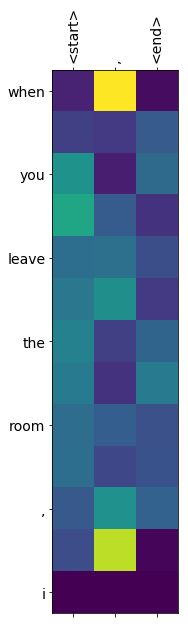

In [68]:
translate(u'कमरे से निकलने से पहले, कृपया बत्तियाँ बंद कर दीजिएगा।', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)

Input: <start>  <end>
Predicted translation: i don t know if she will leave for my mother . <end> 


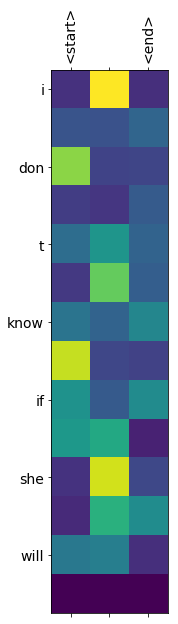

In [69]:
translate(u'आप कहाँ जा रहे हैं', encoder, decoder, inp_lang, targ_lang, max_length_inp, max_length_targ)

## Next steps

* [Download a different dataset](http://www.manythings.org/anki/) to experiment with translations, for example, English to German, or English to French.
* Experiment with training on a larger dataset, or using more epochs
